In [1]:
import json
#import pydevd
#pydevd.settrace('localhost', port=49309, stdoutToServer=True, stderrToServer=True)
import tensorflow as tf

import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import OrderedDict, defaultdict
from six.moves import xrange
#from __pynauty__ import graph
#import pynauty.graph
import pynauty
import time
import tensorflow as tf
import networkx as nx
import numpy as np
import pynauty as nauty
from multiprocessing import Pool
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import os


from PatchyTools import Dataset, utils

### Load data

In [2]:

'''
#Node id is made to start from 0 due to nauty package requirement, even if it starts from 1 in the original
#Graph id is starting from 1
'''

mutag = Dataset.dropbox('MUTAG')
df_edge_label = mutag.get_edge_label()
df_graph_ind = mutag.get_graph_ind()
df_adj = mutag.get_adj()

df_node_label = mutag.get_node_label()
df_node_label = pd.concat([df_node_label, df_graph_ind.graph_label], axis=1)

del df_graph_ind



### Functions

In [3]:

def get_subset_adj(df_adj, df_node_label,graph_label_num):
    df_glabel = df_node_label[df_node_label.graph_label == graph_label_num ]
    index_of_glabel = (df_adj['to'].isin(df_glabel.node) & df_adj['from'].isin(df_glabel.node))
    return df_adj[index_of_glabel]

def get_smallest_node_id_from_adj(df_adj):
    return min(df_adj['to'].min(), df_adj['from'].min())


def create_adj_dict_by_graphId(df_adj, df_node_label):
    '''
    input: df_node_label
    return: {1: {0:[0,2,5]}} = {graphId: {nodeId:[node,node,node]}}
    '''
    adj_dict_by_graphId ={}
    unique_graph_labels = df_node_label.graph_label.unique()
    for l in unique_graph_labels:
        df_subset_adj = get_subset_adj(df_adj, df_node_label, graph_label_num=l)        
        smallest_node_id = get_smallest_node_id_from_adj(df_subset_adj)
        df_subset_adj -= smallest_node_id
        adj_dict_by_graphId[l] = df_subset_adj
    return adj_dict_by_graphId


def canonical_labeling(adj_dict_by_graphId, df_node_label, df_adj):
    all_canonical_labels =[]
    unique_graph_labels = df_node_label.graph_label.unique()
    for l in unique_graph_labels:
        df_subset_adj = adj_dict_by_graphId[l]
        df_subset_nodes = df_node_label[df_node_label.graph_label==l]        
        temp_graph_dict = utils.dfadj_to_dict(df_subset_adj)
        nauty_graph = nauty.Graph(len(temp_graph_dict), adjacency_dict=temp_graph_dict)
        canonical_labeling = nauty.canonical_labeling(nauty_graph)        
        canonical_labeling = [df_subset_nodes.label.values[i] for i in canonical_labeling] ###
        all_canonical_labels += canonical_labeling
    return all_canonical_labels


def create_adj_coomatrix_by_graphId(adj_dict_by_graphId, df_node_label):
    """
    return: a coomatrix per graphId
    """
    
    adj_coomatrix_by_graphId ={}
    unique_graph_labels = df_node_label.graph_label.unique()
    for l in unique_graph_labels:
        df_subset_adj = adj_dict_by_graphId[l]
        df_subset_node_label = df_node_label[df_node_label.graph_label == l]
        adjacency = coo_matrix(( np.ones(len(df_subset_adj)), 
                                (df_subset_adj.iloc[:,0].values, df_subset_adj.iloc[:,1].values) ), 
                                 shape=(len(df_subset_node_label), len(df_subset_node_label))
                              )
        adj_coomatrix_by_graphId[l]=adjacency
    return adj_coomatrix_by_graphId

def make_naighbor(adj_coomatrix_by_graphId, df_node_label):
    
    """
    return: a dictionary with the shape of {graphId:[matrix: node x neighbor]} 
    The size of 2D matrix is (Node number) x (NEIGHBOR_SIZE). 
    """
    
    neighborhoods_dict={}
    
    unique_graph_labels = df_node_label.graph_label.unique()
    for l in unique_graph_labels:
        adjacency = adj_coomatrix_by_graphId[l]
        graph = nx.from_numpy_matrix(adjacency.todense())
        
        neighborhoods = np.zeros((adjacency.shape[0], NEIGHBOR_SIZE), dtype=np.int32)
        # If the NEIGHBOR_SIZE exceeds the number of actual neighbor nodes, then fill them with -1
        neighborhoods.fill(-1) 
        
        df_sequence = df_node_label[df_node_label.graph_label == l]
        df_sequence = df_sequence.sort_values(by='cano_label')
        smallest_node_id = df_sequence.node.min()
                
        # CUT GRAPH BY THRESHOLD of cano_label
        df_sequence = df_sequence.loc[df_sequence.cano_label <= LABEL_THRESHOLD]
        df_sequence['node'] = df_sequence.node.values  - smallest_node_id        
        
        for i, node in enumerate(df_sequence.node):
            shortest = nx.single_source_dijkstra_path_length(graph, node).items()
            shortest = sorted(shortest, key=lambda v: v[1])
            shortest = shortest[:NEIGHBOR_SIZE]
            for j in range(0, min(NEIGHBOR_SIZE, len(shortest))):
                neighborhoods[i][j] = shortest[j][0]
        
        neighborhoods_dict[l] = neighborhoods.copy()
    return neighborhoods_dict

print('start canonical_labeling')



start canonical_labeling


# Main (Timing starts here)

### Arguments  

In [4]:
#NUM_NODES 
LABEL_THRESHOLD = 2 #threshold of canonical label
NEIGHBOR_SIZE = 4

In [5]:
adj_dict_by_graphId = create_adj_dict_by_graphId(df_adj, df_node_label)
cano_label = canonical_labeling(adj_dict_by_graphId, df_node_label, df_adj)
df_node_label = pd.concat([df_node_label, pd.Series(cano_label, dtype=int, name='cano_label')],  axis=1)

now = time.time()
#cert_list = [i for i in (nauty.certificate(nauty_graph))]
# '''canonical_labeling = [df_node_label.label.values[i] for i in canonical_labeling]'''

###### Show the frequency of labels to make threshold

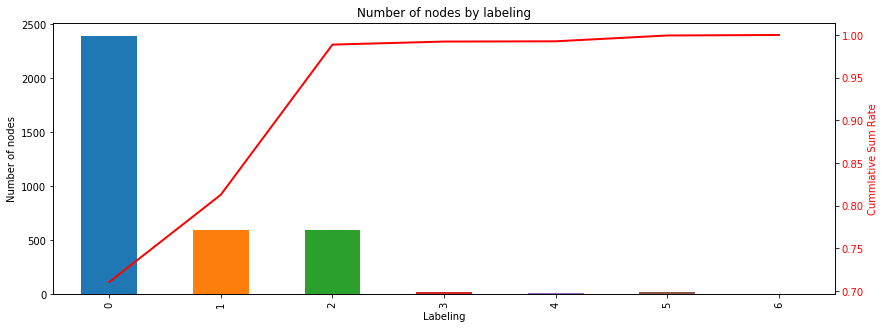

In [6]:
df_node_label.cano_label.value_counts().plot(kind='bar')
df_node_label.cano_label.value_counts().sort_index().plot(kind='bar',  figsize=(14,5))

plt.title('Number of nodes by labeling')
plt.xlabel('Labeling')
plt.ylabel('Number of nodes')

_SUM_ALL_NODES = df_node_label.shape[0]

plt.twinx()
plt.ylabel("Cummlative Sum Rate", color="r")
plt.tick_params(axis="y", labelcolor="r")
plt.plot(df_node_label.cano_label.value_counts().sort_index().index, 
         df_node_label.cano_label.value_counts().sort_index().cumsum() /_SUM_ALL_NODES, "r-", linewidth=2)

plt.show()

### Get several nodes with a condition of cano_label (sequence)

In [7]:
adj_coomatrix_by_graphId = create_adj_coomatrix_by_graphId(adj_dict_by_graphId, df_node_label)
neighborhoods_graph = make_naighbor(adj_coomatrix_by_graphId, df_node_label)

### Things about tensorflow constraction

In [8]:
"""

neighborhoods[graphId]: This represents the matrix of (nodes x neighbor).
nodes: This represents the matrix of (nodes x features).

"""

'\n\nneighborhoods[graphId]: This represents the matrix of (nodes x neighbor).\nnodes: This represents the matrix of (nodes x features).\n\n'

In [9]:
feature_list = df_node_label['label'].unique()
num_features = len(feature_list)


graph_id =1
def main_timing(graph_id):
    neighborhoods = tf.constant(neighborhoods_graph[graph_id], dtype=tf.int32)
    sparse_df = pd.get_dummies(df_node_label.loc[df_node_label.graph_label==graph_id].label, 
                               columns=feature_list,
                               sparse=True
                              )
    
    #### Reindex and transporse to get columns of get dummy #########
    sparse_df = sparse_df.T.reindex(feature_list).T.fillna(0)
    
    nodes = tf.constant(
        sparse_df.values,
        dtype=tf.int32 )
    
    with tf.Session() as sess:
        data = tf.reshape(neighborhoods, [-1])
        i = tf.maximum(data, 0)
        i_list = i.eval()
        #print(i_list)
        #print('')

        for ind, i in enumerate(i_list):
            if ind ==0: 
                positive = tf.strided_slice(nodes, [i], [i+1], [1])
                #positive = tf.constant(temp)
            else:
                temp = tf.strided_slice(nodes, [i], [i+1], [1])
                positive = tf.concat([positive,temp],axis=0)

        negative = tf.zeros([positive.shape[0], positive.shape[1]], dtype= tf.int32)

        #print ('shape', data.shape, negative.shape, positive.shape)
        #print ( data, negative, positive)

        # padding with 0 here because -1 indicates there is no neighbor nodes.
        ret = tf.where(data < 0, negative, positive)
        #print('padding done')


        ret = tf.reshape(ret, 
                         [neighborhoods.shape[0], 
                          NEIGHBOR_SIZE, # This is equals to neighborhoods.shape[1]
                          num_features])



# Timing

In [ ]:
for key in tqdm(adj_dict_by_graphId.keys()):
    main_timing(key)
    
print ('time passed in seconds', ("%.2f"%(time.time() - now)))